#  Replicating Hochberg book
## Charge simulation

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import tidy3d as td
from generate_mesh import gen_mesh

import devsim as ds

In [2]:
# all units in um
w_core = 0.25
h_core = 0.22

w_clearance = 2.25
h_clearance = 0.09
w_side = 2.5
h_side = 0.22

w_contact = 1.2
h_contact = 0.2
h_contact = 1.

z_size = h_clearance/5

res = h_clearance/10

### Generate 2D doping

In [3]:
import doping_hochberg as doping
# doping with boxes
acceptor_boxes, donor_boxes = doping.generate_doping_boxes()


### Create mediums

In [4]:
# if the frequency range were valid to 0 we could define the material as
SiO2_optic = td.material_library['SiO2']['Palik_Lossless']
SiO2 = td.MultiPhysicsMedium(
    optical=SiO2_optic,
    charge=td.ChargeInsulatorMedium(permittivity=SiO2_optic.eps_model(frequency=0)), 
    name="SiO2",
)

# Let's create our own material since
#    1. The above material is not well defined for frequency=0 (out of validity region)
#    2. The mode solver doesn't yet support Multiphysics mediums
SiO2 = td.MultiPhysicsMedium(
    optical=td.Medium(permittivity=3.9),
    charge=td.ChargeInsulatorMedium(permittivity=3.9), # redefining permittivity
    name="SiO2",
)

# auxiliary materials we use to define BCs
aux_left = td.MultiPhysicsMedium(
    charge=td.ChargeConductorMedium(conductivity=1),
    name="aux_left"
)

aux_right = td.MultiPhysicsMedium(
    charge=td.ChargeConductorMedium(conductivity=1),
    name="aux_right"
)

air = td.Medium(heat_spec=td.FluidSpec(), name="air")

20:19:12 CET WARNING: frequency passed to 'Medium.eps_model()'is outside of     
             'Medium.frequency_range' = (59958491600000.0, 1998616386666666.8)  

/home/marc/Documents/tidy3D_python/tidy3d_local/lib/python3.12/site-packages/pydantic/v1/validators.py:157: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(v)


#### Semiconductor medium

In [5]:
# Create a semiconductor medium with mobility, generation-recombination, and bandgap narrowing models.
intrinsic_si = td.SemiconductorMedium(
    permittivity=11.7,
    N_c=2.86e19,
    N_v=3.1e19,
    E_g=1.11,
    mobility=td.CaugheyThomasMobility(
        mu_n_min=52.2,
        mu_n=1471.0,
        mu_p_min=44.9,
        mu_p=470.5,
        exp_t_mu=-2.33,
        exp_d_n=0.68,
        exp_d_p=0.719,
        ref_N=2.23e17,
        exp_t_mu_min=-0.57,
        exp_t_d=2.4,
        exp_t_d_exp=-0.146,
    ),
    R=[
        td.ShockleyReedHallRecombination(tau_n=3.3e-6, tau_p=4e-6),
        td.RadiativeRecombination(r_const=1.6e-14),
        td.AugerRecombination(c_n=2.8e-31, c_p=9.9e-32),
    ],
    delta_E_g=td.SlotboomBandGapNarrowing(
        v1=6.92 * 1e-3,
        n2=1.3e17,
        c2=0.5,
        min_N=1e15,
    ),
    N_a=0,
    N_d=0,
)

# For Si one can also import from library (this is equivalent to the above intrinsic_si)
intrinsic_si2 = td.material_library['cSi'].variants['Si_MultiPhysics'].medium.charge

In [6]:
Si_2D_doping = td.MultiPhysicsMedium(
    charge=intrinsic_si.updated_copy(
        N_d=donor_boxes,
        N_a=acceptor_boxes,
    ),
    name="Si_doping",
)

### Generate structures

In [7]:
# create objects
overlap_factor = 1.0001

oxide = td.Structure(
    geometry=td.Box(center=(0, h_core, 0), size=(10, 5, z_size)),
    medium=SiO2,
    name="oxide"
)

core_p = td.Structure(
    geometry=td.Box(center=(-w_core/2, h_core/2, 0), size=(w_core, h_core, z_size)),
    medium=Si_2D_doping,
    name="core_p"
)

core_n = td.Structure(
    geometry=td.Box(center=(w_core/2, h_core/2, 0), size=(w_core, h_core, z_size)),
    medium=Si_2D_doping,
    name="core_n"
)

clearance_p = td.Structure(
    geometry=td.Box(center=(-w_core - w_clearance/2, h_clearance/2, 0), size=(w_clearance, h_clearance, z_size)),
    medium=Si_2D_doping,
    name="clearance_p"
)

clearance_n = td.Structure(
    geometry=td.Box(center=(w_core + w_clearance/2, h_clearance/2, 0), size=(w_clearance, h_clearance, z_size)),
    medium=Si_2D_doping,
    name="clearance_n"
)

side_p = td.Structure(
    geometry=td.Box(center=(-w_core - w_clearance - w_side/2, h_side/2, 0), size=(w_side, h_side, z_size)),
    medium=Si_2D_doping,
    name="side_p"
)

side_n = td.Structure(
    geometry=td.Box(center=(w_core + w_clearance + w_side/2, h_side/2, 0), size=(w_side, h_side, z_size)),
    medium=Si_2D_doping,
    name="side_n"
)

# create a couple structs to define the contacts
contact_left = td.Structure(
    geometry=td.Box(center=(-w_core - w_clearance - w_side + w_contact/2, h_side + h_contact/2, 0), size=(w_contact, h_contact, z_size)),
    medium=aux_left,
    name="contact_left"
)

contact_right = td.Structure(
    geometry=td.Box(center=(w_core + w_clearance + w_side - w_contact/2, h_side + h_contact/2, 0), size=(w_contact, h_contact, z_size)),
    medium=aux_right,
    name="contact_right"
)

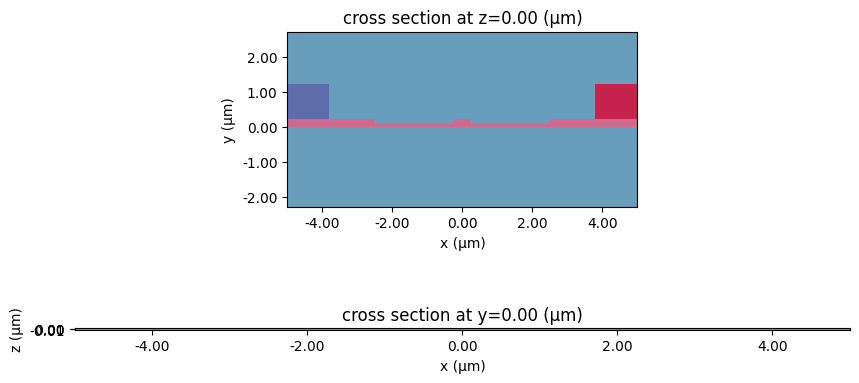

In [8]:
# create a scene with the previous structures
all_structures = [oxide, core_p, core_n, clearance_n, clearance_p, side_p, side_n, contact_left, contact_right]

scene = td.Scene(
    medium=air,
    structures=all_structures,
)


_, ax = plt.subplots(2, 1, figsize=(10, 5))

scene.plot(z=0, ax=ax[0])
scene.plot(y=5e-6, ax=ax[1])
plt.show()

<Axes: title={'center': 'cross section at z=0.00 (μm)'}, xlabel='x (μm)', ylabel='y (μm)'>

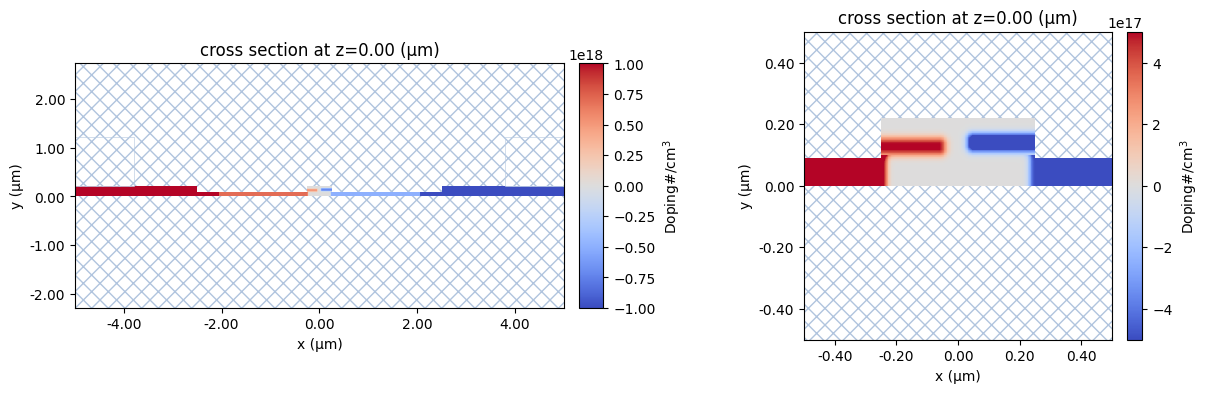

In [9]:
# plot doping from scene
_, ax = plt.subplots(1,2, figsize=(15, 4))
scene.plot_structures_property(z=0, property="doping", ax=ax[0], limits=[-1e18,1e18])
scene.plot_structures_property(z=0, property="doping", ax=ax[1], hlim=[-0.5,0.5], vlim=[-0.5,0.5], limits=[-5e17,5e17])


### BCs

In [10]:
# create BCs
voltages = [-0.5, 0, 1, 2, 3, 4]

bc_v1 = td.HeatChargeBoundarySpec(
    condition=td.VoltageBC(source=td.DCVoltageSource(voltage=0)),
    placement=td.StructureBoundary(structure=contact_left.name),
)

bc_v2 = td.HeatChargeBoundarySpec(
    condition=td.VoltageBC(source=td.DCVoltageSource(voltage=voltages)),
    placement=td.StructureBoundary(structure=contact_right.name),
)

boundary_conditions = [bc_v1, bc_v2]

### Monitors

In [11]:
# capacitance monitors
capacitance_global_mnt = td.SteadyCapacitanceMonitor(
    center=(0, 0.14, 0), size=(td.inf, td.inf, 0), name="capacitance_global_mnt",
)

# charge monitor around the waveguide
capacitance_wvg_mnt = td.SteadyCapacitanceMonitor(
    center=(0, 0.14, 0), size=(0.6, 0.3, 0), name="capcitance_wvg_mnt",
)

# charge monitor around the waveguide
charge_3D_mnt = td.SteadyFreeCarrierMonitor(
    center=(0, 0.14, 0), size=(0.6, 0.3, td.inf), name="charge_3D_mnt", unstructured=True
)

charge_monitor_z0 = td.SteadyFreeCarrierMonitor(
    center=(0, 0.14, 0), size=(0.6, 0.3, 0), name="charge_z0", unstructured=True, 
)

# voltage monitor around waveguide
voltage_monitor_z0 = td.SteadyPotentialMonitor(
    center=(0, 0.14, 0), size=(0.6, 0.3, 0), name="voltage_z0", unstructured=True, 
)

# Will be used later for the mode simulations
charge_monitor_z0_big = td.SteadyFreeCarrierMonitor(
    center=(0, 0.14, 0), size=(td.inf, td.inf, 0), name="charge_z0_big", unstructured=True, conformal=True
)

### Create simulation

In [12]:
# devsim setting 
convergence_settings = td.ChargeToleranceSpec(rel_tol=1e5, abs_tol=3e3, max_iters=400)

# currently we support Isothermal cases only. Temperature in K
analysis_type = td.IsothermalSteadyChargeDCAnalysis(temperature=300, tolerance_settings=convergence_settings, convergence_dv=10)

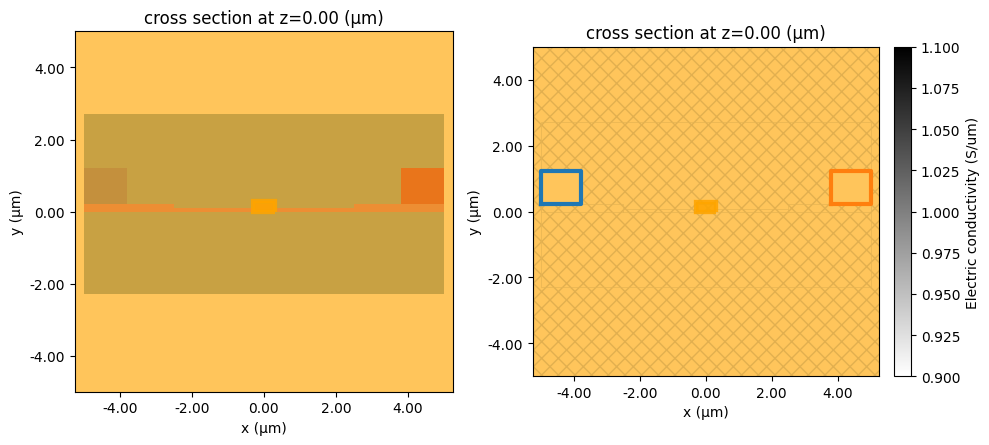

In [13]:
# mesh
mesh = td.DistanceUnstructuredGrid(dl_interface=res*1.15, dl_bulk=res*4, distance_interface=0.02*h_side,
    distance_bulk=1*h_side, relative_min_dl=0,
    uniform_grid_mediums=[Si_2D_doping.name],
    non_refined_structures=[oxide.name]
)

# build heat simulation object
charge_sim = td.HeatChargeSimulation(
    sources=[],
    monitors=[capacitance_global_mnt, capacitance_wvg_mnt, charge_3D_mnt, charge_monitor_z0, voltage_monitor_z0, charge_monitor_z0_big],
    analysis_spec=analysis_type,
    center=(0,0,0),
    size=(10.5,10,5),
    structures=all_structures,
    medium=air,
    boundary_spec=boundary_conditions,
    grid_spec=mesh,
    symmetry=(0, 0, 0)
    )

# plot simulation
fig, ax = plt.subplots(1, 2, figsize=(10, 15))
charge_sim.plot(z=0, ax=ax[0])
charge_sim.plot_property(z=0, property="electric_conductivity", ax=ax[1])
plt.tight_layout()
plt.show()

### Run pipeline

In [14]:
#%matplotlib inline
#from run_drift import run_drift
#charge_data = run_drift(charge_sim)

# run on server
from tidy3d import web
charge_data=web.run(charge_sim, task_name="test_prash", solver_version="dd-devsim-0.0.0", path="charge_web.hdf5")

20:19:18 CET Created task 'test_prash' with task_id                             
             'he-f704d3ea-cc64-4ba1-b87d-1ec72d255588' and task_type 'HEAT'.

             Tidy3D's Heat solver is currently in the beta stage. Cost of Heat  
             simulations is subject to change in the future.

             View task using web UI at                                          
             ]8;id=53290;https://tidy3d.simulation.cloud/workbench?taskId=he-f704d3ea-cc64-4ba1-b87d-1ec72d255588\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=491531;https://tidy3d.simulation.cloud/workbench?taskId=he-f704d3ea-cc64-4ba1-b87d-1ec72d255588\taskId]8;;\]8;id=53290;https://tidy3d.simulation.cloud/workbench?taskId=he-f704d3ea-cc64-4ba1-b87d-1ec72d255588\=]8;;\]8;id=884126;https://tidy3d.simulation.cloud/workbench?taskId=he-f704d3ea-cc64-4ba1-b87d-1ec72d255588\he]8;;\]8;id=53290;https://tidy3d.simulation.cloud/workbench?taskId=he-f704d3ea-cc64-4ba1-b87d-1ec72d255588\-f704d3ea-cc64-]8;;\
             ]8;id=53290;https://tidy3d.simulation.cloud/workbench?taskId=he-f704d3ea-cc64-4ba1-b87d-1ec72d255588\4ba1-b87d-1ec72d255588']8;;\.

Output()

20:19:35 CET Maximum FlexCredit cost: 0.025. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

20:19:36 CET status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

20:20:05 CET status = preprocess

20:29:51 CET status = postprocess

20:32:39 CET status = success

             starting up solver

             running solver

20:32:40 CET status = success

             View simulation result at                                          
             ]8;id=444697;https://tidy3d.simulation.cloud/workbench?taskId=he-f704d3ea-cc64-4ba1-b87d-1ec72d255588\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=682480;https://tidy3d.simulation.cloud/workbench?taskId=he-f704d3ea-cc64-4ba1-b87d-1ec72d255588\taskId]8;;\]8;id=444697;https://tidy3d.simulation.cloud/workbench?taskId=he-f704d3ea-cc64-4ba1-b87d-1ec72d255588\=]8;;\]8;id=94716;https://tidy3d.simulation.cloud/workbench?taskId=he-f704d3ea-cc64-4ba1-b87d-1ec72d255588\he]8;;\]8;id=444697;https://tidy3d.simulation.cloud/workbench?taskId=he-f704d3ea-cc64-4ba1-b87d-1ec72d255588\-f704d3ea-cc64-]8;;\
             ]8;id=444697;https://tidy3d.simulation.cloud/workbench?taskId=he-f704d3ea-cc64-4ba1-b87d-1ec72d255588\4ba1-b87d-1ec72d255588']8;;\.

Output()

20:32:44 CET loading simulation from charge_web.hdf5

             WARNING: Could not execute validator 'warn_no_data' because field  
             'monitor' failed validation.                                       

             WARNING: Could not execute validator 'warn_no_data' because field  
             'monitor' failed validation.                                       

             WARNING: Could not execute validator 'warn_no_data' because field  
             'monitor' failed validation.                                       

             WARNING: Could not execute validator 'warn_no_data' because field  
             'monitor' failed validation.                                       

             WARNING: Could not execute validator 'warn_no_data' because field  
             'monitor' failed validation.                                       

### Post-process Charge simmulation

/home/marc/Documents/tidy3D_python/tidy3d_local/lib/python3.12/site-packages/xarray/core/computation.py:821: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


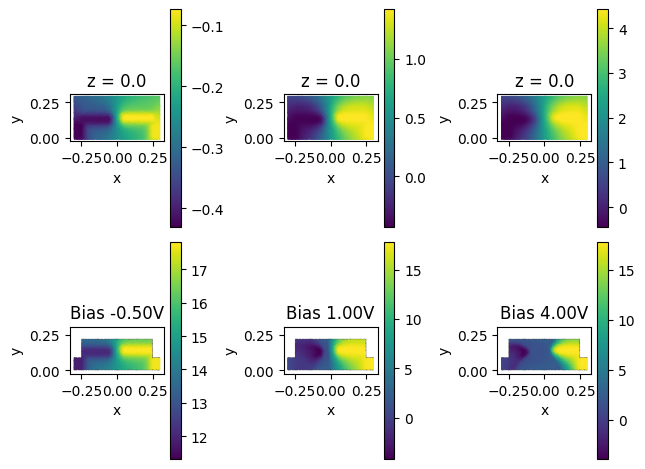

In [15]:
voltages = charge_data[charge_3D_mnt.name].holes.values.voltage.data

fig, ax = plt.subplots(2, 3)
for n, index in enumerate([0,2,5]):
    # let's read voltage first
    charge_data[voltage_monitor_z0.name].potential.sel(voltage=voltages[index]).plot(ax=ax[0][n], grid=False)

    # now let's plot some electrons
    np.log10(charge_data[charge_3D_mnt.name].electrons.sel(z=0, voltage=voltages[index])).plot(ax=ax[1][n], grid=False)
    ax[1][n].set_title("Bias {0:0.2f}V".format(voltages[index]))

plt.tight_layout()

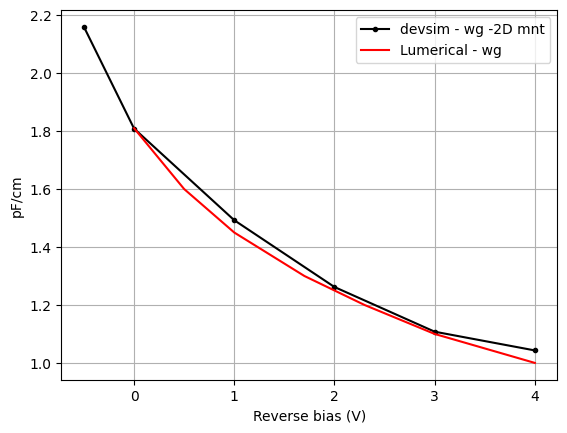

In [16]:
# capacitance from monitor - waveguide area
c_lumerical_wg_in_SiO2 = np.array([0.181, 0.16, 0.145, 0.13, 0.12, 0.11, 0.1])
b_lumerical_wg_in_SiO2 = np.array([0,     0.5,   1,    1.7,  2.3,  3,     4])


mnt_v = np.array(charge_data[capacitance_wvg_mnt.name].hole_capacitance.coords["v"].data)
mnt_ce = np.array(charge_data[capacitance_wvg_mnt.name].electron_capacitance.data)
mnt_ch = np.array(charge_data[capacitance_wvg_mnt.name].hole_capacitance.data)

plt.plot(mnt_v, -0.5*(mnt_ce+mnt_ch) * 10, 'k.-', label="devsim - wg -2D mnt")
plt.plot(b_lumerical_wg_in_SiO2, c_lumerical_wg_in_SiO2*10, 'r-', label="Lumerical - wg")

plt.xlabel("Reverse bias (V)")
plt.ylabel("pF/cm")
plt.legend()
plt.grid()
#charge_data[charge_monitor_z0.name].capacitance_curve["cv_curve_e"].plot()

### Comparison against experimental data

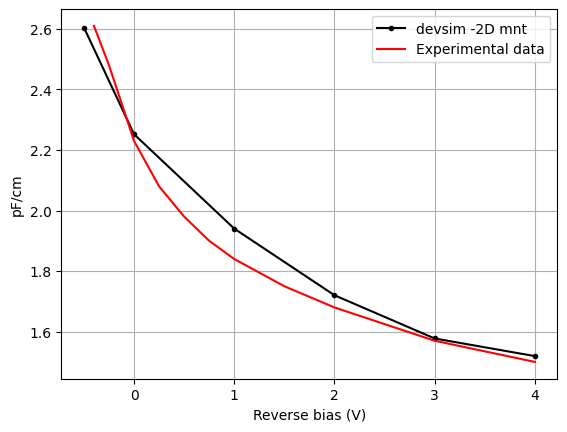

In [17]:
# capacitance from monitor - waveguide area
CV_baehrjones = [
    [-0.4, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.5, 2, 3, 4],
    [0.261, 0.248, 0.223, 0.208, 0.198, 0.190, 0.184, 0.175, 0.168, 0.157, 0.150]]


mnt_v = np.array(charge_data[capacitance_global_mnt.name].electron_capacitance.coords["v"].data)
mnt_ce = np.array(charge_data[capacitance_global_mnt.name].electron_capacitance.data)
mnt_ch = np.array(charge_data[capacitance_global_mnt.name].hole_capacitance.data)

plt.plot(mnt_v, -0.5*(mnt_ce+mnt_ch) * 10 , 'k.-', label="devsim -2D mnt")
plt.plot(CV_baehrjones[0], np.array(CV_baehrjones[1])*10, 'r-', label="Experimental data")

plt.xlabel("Reverse bias (V)")
plt.ylabel("pF/cm")
plt.legend()
plt.grid()

## Generate Charge-dependent perturbation material

In [18]:
# define first the range of frequencies of interest

wvl_um = 1.55
freq0 = td.C_0 / wvl_um

fwidth = freq0 / 5
freqs = np.linspace(freq0 - fwidth / 10, freq0 + fwidth / 10, 201)
wvls = td.C_0 / freqs

In [19]:
si = td.material_library['cSi']['Palik_Lossless']

n_si, k_si = si.nk_model(frequency=td.C_0 / wvl_um)

In [20]:
ne_coeff = -5.4e-22 * 1.1
ne_pow = 1.011

nh_coeff = -1.53e-18 * 1.1
nh_pow = 0.838

k_factor = wvl_um * 1e-4 / 4 / np.pi  # factor for conversion from absorption coefficient into k

ke_coeff = k_factor * 8.88e-21 * 1.1
ke_pow = 1.167

kh_coeff = k_factor * 5.84e-20 * 1.1
kh_pow = 1.109

In [21]:
Ne_range = np.concatenate(([0], np.logspace(-6, 20, num=200)))
Nh_range = np.concatenate(([0], np.logspace(-6, 20, num=200)))

Ne_mesh, Nh_mesh = np.meshgrid(Ne_range, Nh_range, indexing='ij')

dn_mesh = ne_coeff * Ne_mesh ** ne_pow + nh_coeff * Nh_mesh ** nh_pow
dk_mesh = ke_coeff * Ne_mesh ** ke_pow + kh_coeff * Nh_mesh ** kh_pow

In [22]:
si_non_perturb = td.Medium.from_nk(n=n_si, k=k_si, freq=freq0)

In [23]:
dn_data = td.ChargeDataArray(dn_mesh, coords=dict(n=Ne_range, p=Nh_range))
dk_data = td.ChargeDataArray(dk_mesh, coords=dict(n=Ne_range, p=Nh_range))

n_si_charge = td.CustomChargePerturbation(perturbation_values=dn_data)
k_si_charge = td.CustomChargePerturbation(perturbation_values=dk_data)

n_si_perturbation = td.ParameterPerturbation(
    charge=n_si_charge,
)

k_si_perturbation = td.ParameterPerturbation(
    charge=k_si_charge,
)

si_perturb = td.PerturbationMedium.from_unperturbed(
    medium=si_non_perturb,
    perturbation_spec=td.IndexPerturbation(
        delta_n=n_si_perturbation,
        delta_k=k_si_perturbation,
        freq=freq0,
    )
)

## Create mode simulation

### Apply perturbation medium to scene

In [24]:
span = 2*wvl_um

In [25]:
new_structs = []
for struct in charge_sim.structures:
    # NOTE: applying perturbation material to Si
    if struct.medium.name == Si_2D_doping.name:
        new_structs.append(struct.updated_copy(medium=si_perturb))

scene = td.Scene(
    #medium=td.Medium(permittivity=3.9),
    medium=SiO2.optical, # currently td.Simulation cannot accpet a MultiphysicsMedium
    structures=new_structs,
)


### Define mode source

In [26]:
buffer = 1*wvl_um

port_center = (0,h_core,-span/2)
port_size = (5, 5, 0)

### Create simulation

In [27]:
sim_size = (13+buffer, 10+buffer, span)
bc_spec = td.BoundarySpec(
    x = td.Boundary.pml(num_layers=20),
    y = td.Boundary.pml(num_layers=30),
    z = td.Boundary.periodic(),
)

sim = td.Simulation(
    center=(0,0,0),
    size=sim_size,
    medium=scene.medium,
    structures=scene.structures,
    run_time=6e-12,
    boundary_spec=bc_spec,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=60, wavelength=wvl_um)
)

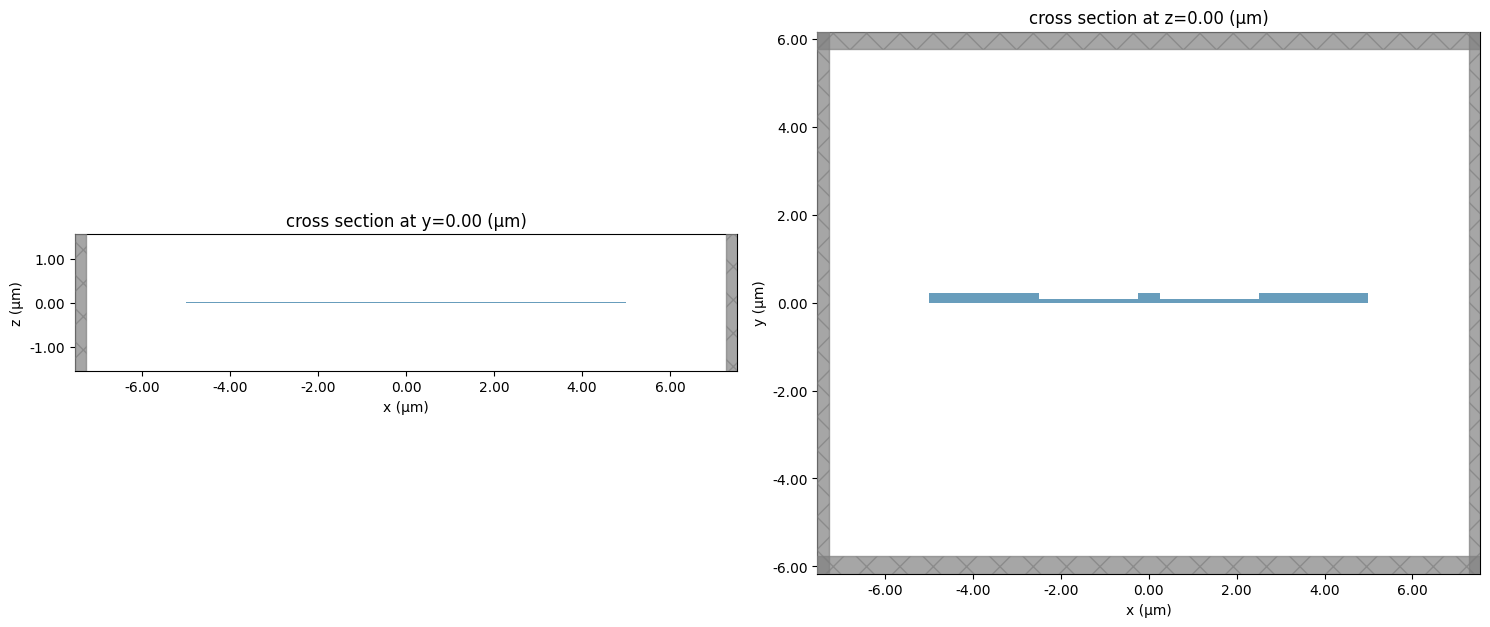

In [28]:
_, ax = plt.subplots(1, 2, figsize=(15, 7))
sim.plot(y=sim.center[1], ax=ax[0])
sim.plot(z=sim.center[2], ax=ax[1])

plt.tight_layout()
plt.show()

In [29]:
def apply_charge(charge_data):
    perturbed_sims = []
    for n, v in enumerate(charge_data[charge_monitor_z0_big.name].electrons.values.voltage.data):
        e_data = charge_data[charge_monitor_z0_big.name].electrons.sel(voltage=v)
        h_data = charge_data[charge_monitor_z0_big.name].holes.sel(voltage=v)
        perturbed_sims.append(
            sim.perturbed_mediums_copy(
                electron_density=e_data, 
                hole_density=h_data,
            )
        )
    return perturbed_sims

perturbed_sims = apply_charge(charge_data)

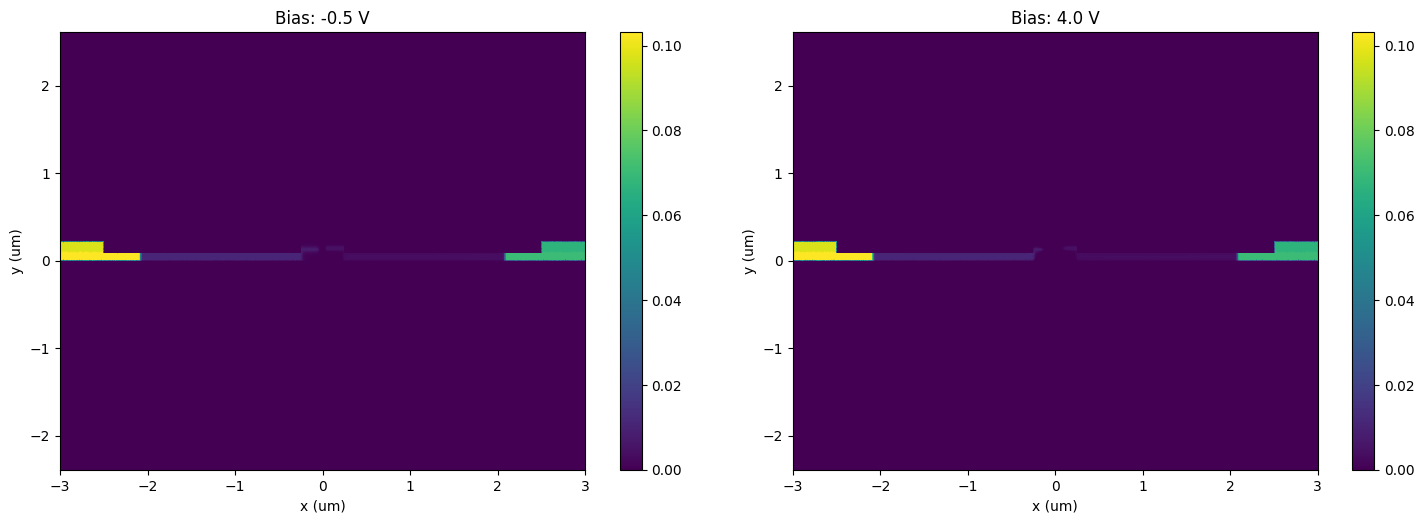

In [30]:
_, ax = plt.subplots(1, 2, figsize=(15, 5))

sampling_region = td.Box(center=(0, h_core/2, 0), size=(6, 5, 1))
#eps_undoped = sim.epsilon(box=sampling_region).isel(z=0, drop=True)
eps_undoped = sim.epsilon(box=sampling_region).sel(z=0, method="nearest")

for ax_ind, ind in enumerate([0, len(voltages)-1]):
    #eps_doped = perturbed_sims[ind].epsilon(box=sampling_region).isel(z=0,  drop=True)
    eps_doped = perturbed_sims[ind].epsilon(box=sampling_region).sel(z=0, method="nearest")
    eps_doped = eps_doped.interp(x=eps_undoped.x, y=eps_undoped.y)
    eps_diff = np.abs(np.real(eps_doped - eps_undoped))
    eps_diff.plot(x="x", ax=ax[ax_ind])
    
    ax[ax_ind].set_aspect("equal")
    ax[ax_ind].set_title(f"Bias: {voltages[ind]:1.1f} V")
    ax[ax_ind].set_xlabel("x (um)")
    ax[ax_ind].set_ylabel("y (um)")

plt.tight_layout()
plt.show()

### Waveguide mode analysis

In [31]:
from tidy3d.plugins.mode import ModeSolver
from tidy3d.plugins.mode.web import run_batch as run_mode_batch

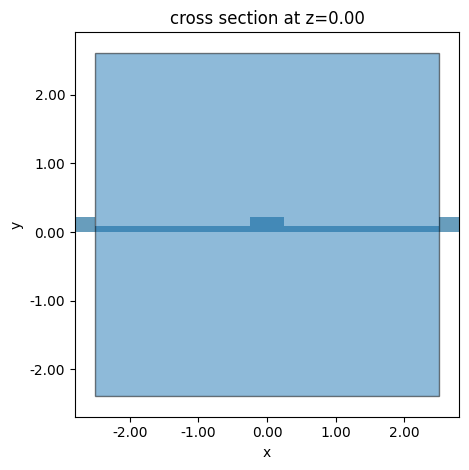

In [32]:
mode_plane = td.Box(center=(0, h_core / 2, 0), size=port_size)

# visualize
ax = sim.plot(z = 0)
mode_plane.plot(z=0, ax=ax, alpha=0.5)
plt.show()

In [33]:
mode_solvers = []
for psim in perturbed_sims:
    ms = ModeSolver(
        simulation=psim,
        plane=mode_plane,
        freqs=np.linspace(freqs[0], freqs[-1], 11),
        mode_spec=td.ModeSpec(num_modes=1, precision="double"),
    )
    mode_solvers.append(ms)

In [34]:
# server mode computation
ms_data = run_mode_batch(mode_solvers=mode_solvers)

20:32:52 CET Running a batch of 6 mode solvers.                                 
             

Output()

             WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

             WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

             WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

             WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

             WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

             WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

20:32:53 CET WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[1]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[1]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[2]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[2]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[3]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[3]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[4]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[4]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[5]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[5]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

20:32:54 CET WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

20:32:55 CET WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

20:36:45 CET A batch of `ModeSolver` tasks completed successfully!

### local run
import sys
sys.path.append("/home/marc/Documents/src/tidy3d-core")
from tidy3d_backend.mode import BackendModeSolver
ms_data = []
for psim in perturbed_sims:
    ms = BackendModeSolver(
        eig_solver="auto",
        thread_size=20,
        thread_size_excluded_parallel_solver=20,
        simulation=psim,
        plane=mode_plane,
        mode_spec=td.ModeSpec(num_modes=1, precision="double"),
        freqs=freqs,
        subpixel_scheme=0,
        #colocate=colocate,
        #direction=direction,
    )
    ms_data.append(ms.solve())

### Visualize 1st mode

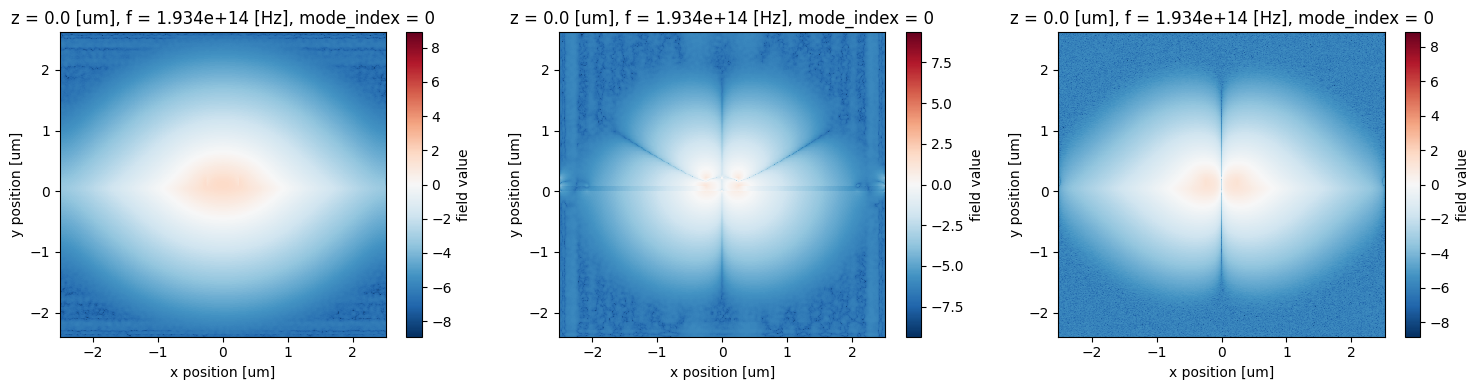

In [35]:
_, ax = plt.subplots(1, 3, figsize=(15, 4))
np.log10(np.abs(ms_data[0].Ex.sel(z=0, f=freq0))).plot(ax=ax[0], x="x")
np.log10(np.abs(ms_data[0].Ey.sel(z=0, f=freq0))).plot(ax=ax[1], x="x")
np.log10(np.abs(ms_data[0].Ez.sel(z=0, f=freq0))).plot(ax=ax[2], x="x")
plt.tight_layout()

### Relative phase change

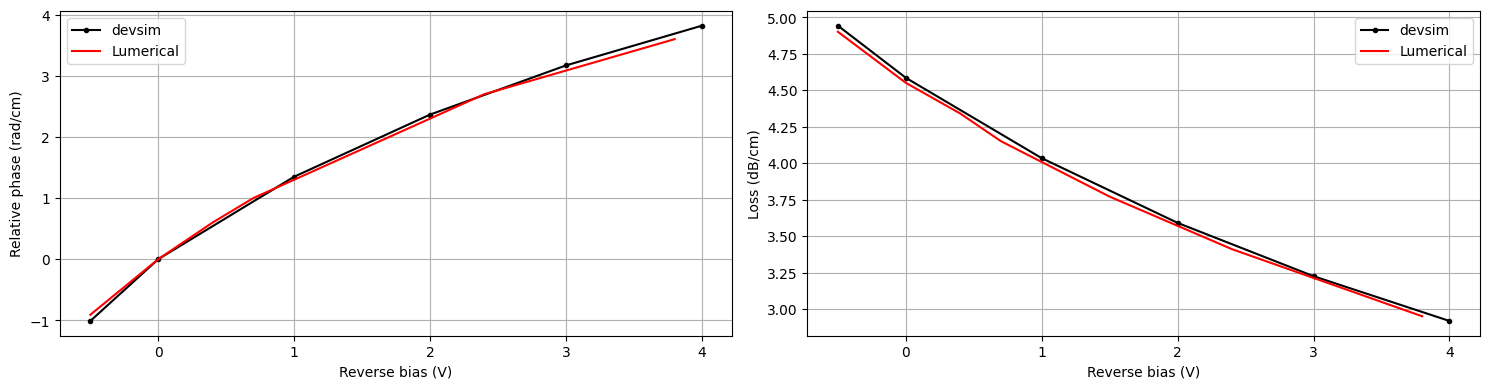

In [36]:
n_eff_freq0 = [md.n_complex.sel(f=freq0, mode_index=0).values for md in ms_data]

ind_V0 = 1
delta_neff = np.real(n_eff_freq0 - n_eff_freq0[ind_V0])
rel_phase_change = 2*np.pi*delta_neff/wvl_um * 1e4
alpha_dB_cm = 10*4*np.pi*np.imag(n_eff_freq0)/wvl_um*1e4*np.log10(np.exp(1))

# lumerical results
v_lumerical = [-0.5, 0, 0.4, 0.7, 1.5, 2.4, 3.8]
pc_lumerical=[-0.91, 0, 0.6, 1,   1.8, 2.7, 3.6]
loss_lumerical = [4.9, 4.55, 4.34, 4.15, 3.77, 3.41, 2.95]

_, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].plot(voltages, rel_phase_change, 'k.-', label="devsim")
ax[0].plot(v_lumerical, pc_lumerical, 'r-', label="Lumerical")
ax[0].set_xlabel("Reverse bias (V)")
ax[0].set_ylabel("Relative phase (rad/cm)")
ax[0].grid()
ax[0].legend()

ax[1].plot(voltages, alpha_dB_cm, 'k.-', label="devsim")
ax[1].plot(v_lumerical, loss_lumerical, 'r-', label="Lumerical")
ax[1].set_xlabel("Reverse bias (V)")
ax[1].set_ylabel("Loss (dB/cm)")
ax[1].grid()
ax[1].legend()
plt.tight_layout()
plt.show()